In [ ]:
pip install bayesian-optimization

In [ ]:
pip install shap

In [ ]:
pip install pycaret

In [ ]:
pip install sktime

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from tqdm import tqdm
import warnings
import scipy 
import lightgbm as lgb
import xgboost as xgb
import sktime
import sklearn as skl
from pycaret.regression import *
warnings.filterwarnings(action='ignore')
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100
#https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch1-Time-Series.html#smape-symmetric-mean-absolute-percentage-error
#과대추정이 과소추정보다 패널티가 적은 LOSS

In [95]:
print("scikit-learn version: {}".format(skl.__version__))

scikit-learn version: 1.0.1


# EDA

In [141]:
train_path = '/content/drive/MyDrive/TASK#/train.csv'
test_path = '/content/drive/MyDrive/TASK#/test.csv'
submission_path = '/content/drive/MyDrive/TASK#/sample_submission.csv'
parameter_path = '/content/drive/MyDrive/TASK#/parameter.csv'
train_df = pd.read_csv(train_path, encoding = 'cp949')
test_df = pd.read_csv(test_path, encoding = 'cp949')
train_df.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [142]:
train_df.tail()
# 여름 (2020.6월부터 2020.8월 말까지)의 전력사용량 데이터
# 1시간 단위위 데이터

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0
122399,60,2020-08-24 23,3204.576,27.1,2.6,75.0,0.0,0.0,1.0,1.0


In [143]:
test_df

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
train_df.describe

<bound method NDFrame.describe of         num      date_time  전력사용량(kWh)  기온(°C)  풍속(m/s)  습도(%)  강수량(mm)  \
0         1  2020-06-01 00    8179.056    17.6      2.5   92.0      0.8   
1         1  2020-06-01 01    8135.640    17.7      2.9   91.0      0.3   
2         1  2020-06-01 02    8107.128    17.5      3.2   91.0      0.0   
3         1  2020-06-01 03    8048.808    17.1      3.2   91.0      0.0   
4         1  2020-06-01 04    8043.624    17.0      3.3   92.0      0.0   
...     ...            ...         ...     ...      ...    ...      ...   
122395   60  2020-08-24 19    4114.368    27.8      2.3   68.0      0.0   
122396   60  2020-08-24 20    3975.696    27.3      1.2   71.0      0.0   
122397   60  2020-08-24 21    3572.208    27.3      1.8   71.0      0.0   
122398   60  2020-08-24 22    3299.184    27.1      1.8   74.0      0.0   
122399   60  2020-08-24 23    3204.576    27.1      2.6   75.0      0.0   

        일조(hr)  비전기냉방설비운영  태양광보유  
0          0.0        0.0    0

In [145]:
train_df.isnull().sum()

num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64

In [146]:
test_df.isnull().sum()

num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

In [147]:
# 60개의 건물로 이루어짐.
# 영문명으로 변수명 변경
cols = ["building_num","d","power","temp","wind","hum",'prec','sun','non-elec','solar']
train_df.columns = cols
cols = ["building_num","d","temp","wind","hum",'prec','sun','non-elec','solar']
test_df.columns = cols

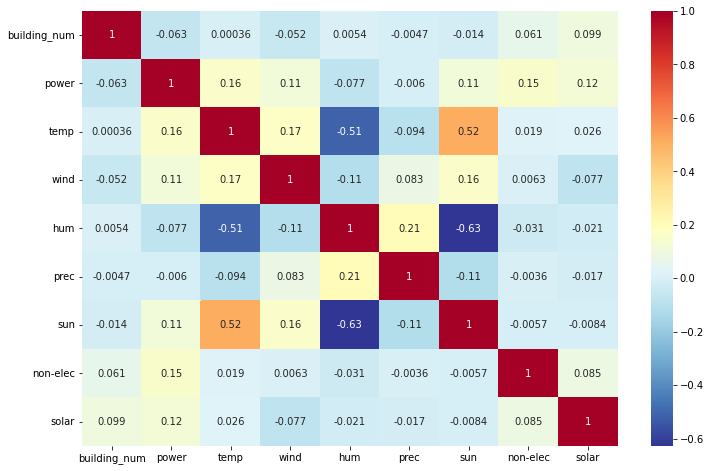

In [148]:
#상관관계 관찰
plt.figure(figsize = (12,8))
sns.heatmap(train_df.corr(),annot = True, cmap = 'RdYlBu_r')
plt.show()

# Preprocessing

In [149]:
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

def preprocessing(train_df):
  # 시간정보 디코딩
  date = pd.to_datetime(train_df.d)
  train_df['hour'] = date.dt.hour
  train_df['day'] = date.dt.weekday
  train_df['month'] = date.dt.month
  train_df['week'] = date.dt.weekofyear

  # hour는 주기적 정보로, 23이 0보다 수치적으로 큰 의미를 갖지 않고, 반복되는 특징을 갖고 때문에 초월함수 수치형으로 인코딩한다. 
  train_df['sin_time'] = np.sin(train_df['hour']/24*2*np.pi)
  train_df['cos_time'] = np.cos(train_df['hour']/24*2*np.pi)

  # 불쾌지수 - 열받으면 에어컨을 더 자주 틀겠지. 
  train_df['THI'] = 9/5*train_df['temp'] - 0.55*(1-train_df['hum']/100)*(9/5*train_df['hum']-26)+32

  # 공휴일 
  train_df['holiday'] = train_df.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
  train_df.loc[('2020-08-17'<=train_df.d)&(train_df.d<'2020-08-18'), 'holiday'] = 1 # 광복절

  cdhs = np.array([])
  for num in range(1,61,1):
      temp = train_df[train_df['building_num'] == num]
      cdh = CDH(temp['temp'].values)
      cdhs = np.concatenate([cdhs, cdh])
  train_df['CDH'] = cdhs

  train = train_df.drop(['d','hour','day','week','month','solar','non-elec'],axis = 1)
  # day week month는 데이터와 상호작용이 거의 없음 - > 의미 없는 데이터? (성능향상여부를 관찰해야함.)
  # solar 와 non elec은 test에서 너무 많은 결측을 가져서 interpolate가 불가능하기 때문에 제거한다. 
  # 종속적 관계의 변수들을 제거한다
  return train

In [150]:
train = preprocessing(train_df)
test = preprocessing(test_df)

for i in range(60):
    test.iloc[i*168:(i+1)*168, :]  = test.iloc[i*168:(i+1)*168, :].interpolate() # 선형보간

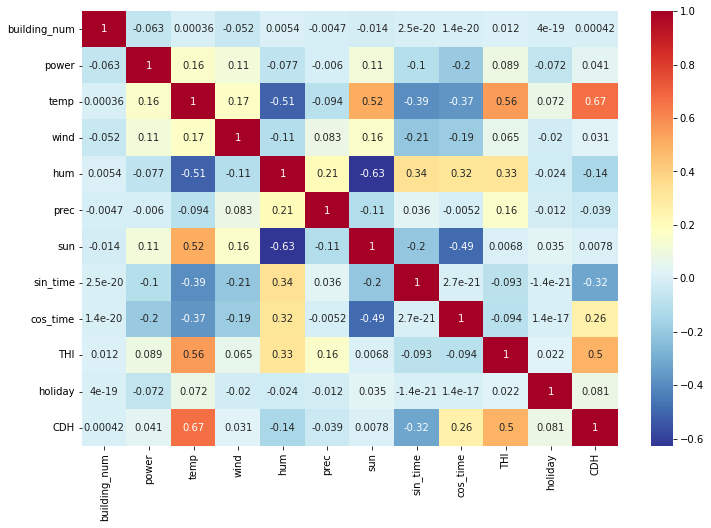

In [151]:
plt.figure(figsize = (12,8))
sns.heatmap(train.corr(),annot = True, cmap = 'RdYlBu_r')
plt.show()

# AUTOML로 감잡기

In [152]:
model1 = setup(train, target = 'power', session_id=970629, log_experiment=True, experiment_name='AUTO')
add_metric('SMAPE','SMAPE',SMAPE ,greater_is_better=False)

,Description,Value
0,session_id,970629
1,Target,power
2,Original Data,"(122400, 12)"
3,Missing Values,False
4,Numeric Features,10
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(85679, 11)"


AttributeError: ignored

In [ ]:
best_model=pycaret.regression.compare_models(fold = 5, sort = 'SMAPE')

""


In [ ]:
# pycaret.regression.interpret_model(best_model)
# 개별 모델 60개를 만들어야 한다. 
# CDH의 추가로 큰 성능 향상이 있었다.
# XAI와 Tree 의 원리를 통해서 생각해 낼 수 있는 solution. 

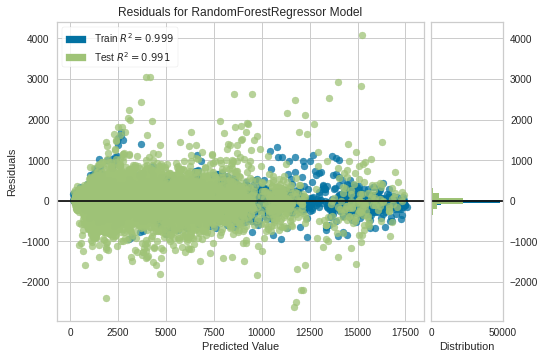

In [ ]:
pycaret.regression.plot_model(best_model)

In [ ]:
pred_array = best_model.predict(test)

In [ ]:
submission = pd.read_csv(submission_path)
submission['answer'] = pred_array
submission.to_csv("/content/drive/MyDrive/TASK#/AUTOML_PRATICE.csv", index = False)

In [ ]:
temp_data= train[train.building_num == 3].drop('building_num',axis = 1)

In [ ]:
model2 = setup(temp_data, target = 'power', session_id=2, log_experiment=True, experiment_name='AUTO2')

def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100
#https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch1-Time-Series.html#smape-symmetric-mean-absolute-percentage-error
#과대추정이 과소추정보다 패널티가 적은 LOSS
add_metric('SMAPE','SMAPE',SMAPE ,greater_is_better=False)

,Description,Value
0,session_id,2
1,Target,power
2,Original Data,"(2040, 11)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1427, 10)"


AttributeError: ignored

In [ ]:
best_model2 = pycaret.regression.compare_models()

""


In [ ]:
best_model

[]

# 60의 데이터로 분류하여 모델링하기 : LGBM

In [153]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
x_train_sets = []
x_valid_sets = []
x_test_sets = []
y_train_sets = []
y_valid_sets = []
y_test_sets = []

for i in tqdm(range(60)):
  temp_train =  train[train.building_num == i+1]
  temp_test = test[test.building_num == i+1]
  y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = temp_train.power , 
                                                                 X = temp_train.drop(['power','building_num'],axis = 1),
                                                                 test_size = 168) # 마지막 일주일
  x_train_sets.append(x_train)
  y_train_sets.append(y_train)
  x_valid_sets.append(x_valid)
  y_valid_sets.append(y_valid)                                                               
  x_test_sets.append(temp_test.drop(['building_num'], axis = 1))

100%|██████████| 60/60 [00:00<00:00, 299.84it/s]


In [154]:
for i in range(60):
  plot_series(y_train_sets[i],y_valid_sets[i], markers = [',',','])
  plt.title("Building_number : "+str(i))

Output hidden; open in https://colab.research.google.com to view.

In [155]:
from sklearn.ensemble import RandomForestRegressor as RF
from lightgbm import LGBMRegressor
model_sets = []
scores = []

lgbm_mae_params = {
    'objective': 'RMSE',
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'early_stopping_round': 15, 
    'num_leaves':39,
} #lightgbm hyper parameter

for i in range(60):
  x_train = x_train_sets[i]
  y_train = y_train_sets[i]
  x_valid = x_valid_sets[i]
  x_valid = x_valid_sets[i]
  regressor = LGBMRegressor(**lgbm_mae_params)
  regressor.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=100) 
  valid_pred = regressor.predict(x_valid)
  score = SMAPE(y_valid, valid_pred)
  scores.append(score)
  model_sets.append(regressor)

[100]	valid_0's rmse: 1970.88
[100]	valid_0's rmse: 2596.39
[100]	valid_0's rmse: 1850.78
[100]	valid_0's rmse: 2338.32
[100]	valid_0's rmse: 949.953
[100]	valid_0's rmse: 2185.45
[100]	valid_0's rmse: 2434.47
[100]	valid_0's rmse: 1870.69
[100]	valid_0's rmse: 2919.53


In [156]:
submission = pd.read_csv(submission_path)
submission

,num_date_time,answer
0,1 2020-08-25 00,0
1,1 2020-08-25 01,0
2,1 2020-08-25 02,0
3,1 2020-08-25 03,0
4,1 2020-08-25 04,0
...,...,...
10075,60 2020-08-31 19,0
10076,60 2020-08-31 20,0
10077,60 2020-08-31 21,0
10078,60 2020-08-31 22,0


In [157]:
for i in range(60):
  temp = pd.Series(model_sets[i].predict(x_valid_sets[i]))
  temp.index = y_valid_sets[i].index
  plot_series(y_train_sets[i],y_valid_sets[i], temp,markers = [',',',',','])
  plt.title("Building_number : "+str(i))

Output hidden; open in https://colab.research.google.com to view.

In [158]:
for i in range(60):
  print("building {} || best score : {}".format(i+1, scores[i]))
  pred = model_sets[i].predict(x_test_sets[i])
  submission.iloc[168*i:168*(i+1),1] = pred

building 1 || best score : 40.47064006487231
building 2 || best score : 45.47651725790378
building 3 || best score : 6.287340985593872
building 4 || best score : 65.4275241518888
building 5 || best score : 11.217274984954019
building 6 || best score : 51.66425196176727
building 7 || best score : 41.38122146399614
building 8 || best score : 41.55610742517234
building 9 || best score : 48.18681519919406
building 10 || best score : 44.750121203124706
building 11 || best score : 19.828234051796116
building 12 || best score : 36.48781914658553
building 13 || best score : 51.840155217895166
building 14 || best score : 31.9977647946692
building 15 || best score : 20.997429172851888
building 16 || best score : 36.00034984423295
building 17 || best score : 56.87723642629632
building 18 || best score : 33.70156375419039
building 19 || best score : 56.18627700327583
building 20 || best score : 40.610717722115936
building 21 || best score : 34.49914243849512
building 22 || best score : 47.24699120

In [159]:
submission.to_csv("/content/drive/MyDrive/TASK#/LGBM_PRATICE.csv", index = False)

#XGB Tuning

In [160]:
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

# 탐색 대상 함수 (XGBRegressor)
def XGB_cv(max_depth,learning_rate, n_estimators, gamma ,min_child_weight, subsample
           ,colsample_bytree, silent=True, nthread=-1):

      # 모델 정의
      model = xgb.XGBRegressor(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                gamma=gamma,
                                min_child_weight=min_child_weight,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree, 
                                nthread=nthread,
                                objective = 'reg:squarederror'
                                )
      # 모델 훈련
      model.fit(X_train, y_train)

      # 예측값 출력
      y_pred= model.predict(X_test)

      # 각종 metric 계산
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      r2 = r2_score(y_test, y_pred)
      smape = SMAPE(y_test, y_pred)
      # 오차 최적화로 사용할 metric 반환
      return -smape

In [161]:
#  bayesian-optimization 라이브러리의 BayesianOptimization 클래스 import
from bayes_opt import BayesianOptimization

X_train = x_train_sets[1]
y_train = y_train_sets[1]
X_test = x_valid_sets[1]
y_test = y_valid_sets[1]

# 실험해보고자하는 hyperparameter 집합
pbounds = {'max_depth': (3, 10),
           'learning_rate': (0.01, 0.2),
           'n_estimators': (50, 500),
           'gamma': (0, 130),
           'min_child_weight': (1, 10),
           'subsample': (0.5, 1),
           'colsample_bytree' :(0.2, 1),
            }

# Bayesian optimization 객체 생성
# f : 탐색 대상 함수, pbounds : hyperparameter 집합
# verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
# random_state : Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제 
bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 ,)    

# 메소드를 이용해 최대화 과정 수행
# init_points :  초기 Random Search 갯수
# n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있다.)
# acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용
# xi : exploration 강도 (기본값은 0.0)
bo.maximize(init_points=2, n_iter=10, acq='ei', xi=0.01)

# ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타냅니다. 
# 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우, 
# bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시하는 것을 확인할 수 있습니다
# 찾은 파라미터 값 확인
print(bo.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -25.55    |  0.5336   |  93.64    |  0.01002  |  5.116    |  2.321    |  91.55    |  0.5931   |
|  2        | -3.131    |  0.4764   |  51.58    |  0.1124   |  5.934    |  7.167    |  142.0    |  0.9391   |
|  3        | -3.039    |  0.3954   |  52.86    |  0.1983   |  5.081    |  5.743    |  143.0    |  0.7931   |
|  4        | -3.021    |  0.2      |  36.28    |  0.2      |  3.0      |  3.729    |  170.5    |  0.5135   |
|  5        | -9.946    |  1.0      |  75.69    |  0.01     |  10.0     |  10.0     |  187.2    |  1.0      |
|  6        | -3.454    |  0.2      |  18.92    |  0.2      |  3.0      |  1.0      |  145.0    |  0.5      |
|  7        | -2.675    |  0.5096   |  7.605    |  0.06876  |  9.397    |  2.391    |  498.1    |  0.5573   |
|  8      

In [166]:
def BayesianOpt():
  optimized_params = []
  pbounds = {'max_depth': (3, 10),
           'learning_rate': (0.01, 0.1),
           'n_estimators': (50, 500),
           'gamma': (0, 120),
           'min_child_weight': (1, 8),
           'subsample': (0.5, 1),
           'colsample_bytree' :(0.2, 1),
            }
  for i in tqdm(range(60)):
    print('\n')
    def XGB_cv(max_depth,learning_rate, n_estimators, gamma
           ,min_child_weight, subsample
           ,colsample_bytree, silent=True, nthread=-1):
      model = xgb.XGBRegressor(max_depth=int(max_depth),
                                learning_rate=learning_rate,
                                n_estimators=int(n_estimators),
                                gamma=gamma,
                                min_child_weight=min_child_weight,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree, 
                                nthread=nthread,
                                objective = 'reg:squarederror'
                                )
      model.fit(X_train, y_train)
      y_pred= model.predict(X_test)
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      r2 = r2_score(y_test, y_pred)
      smape = SMAPE(y_test, y_pred)
      return -smape
    X_train = x_train_sets[i]
    y_train = y_train_sets[i]
    X_test = x_valid_sets[i]
    y_test = y_valid_sets[i]
    bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 )    
    bo.maximize(init_points=2, n_iter=20, acq='ei', xi=0.01)
    optimized_params.append(bo.max)
  return optimized_params

In [167]:
optimized_params = BayesianOpt()

  0%|          | 0/60 [00:00<?, ?it/s]



|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -25.63    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -0.2993   |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -0.285    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -0.2899   |  0.3608   |  29.6     |  0.1      |  5.423    |  6.48     |  168.1    |  0.9538   |
|  5        | -8.315    |  1.0      |  71.47    |  0.01     |  10.0     |  8.0      |  192.8    |  1.0      |
|  6        | -0.2917   |  0.2      |  13.22    |  0.1      |  3.0      |  1.0      |  142.6    |  0.5      |
|  7        | -0.3342   |  0.8641   |  32.13    |  0.04969  |  5.209    |  1.302    |  151.2    |  0.5611   |
|  8    

  2%|▏         | 1/60 [00:22<21:45, 22.12s/it]

|  22       | -0.3111   |  1.0      |  82.48    |  0.1      |  10.0     |  8.0      |  336.2    |  0.5      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -25.58    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.357    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.516    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -12.48    |  0.807    |  24.15    |  0.01     |  10.0     |  8.0      |  161.5    |  1.0      |
|  5        | -4.629    |  0.2      |  35.47    |  0.1      |  3.0      |  1.0      |  126.1    |  0.5      |
|  6        | -6.87     |  0.7966   |  88.74    |  0.01229  |  7.823    |  7.583    |  181.7    |  0.94     |
|  7    

  3%|▎         | 2/60 [00:45<22:15, 23.03s/it]

|  22       | -2.634    |  1.0      |  0.0282   |  0.01     |  3.0      |  8.0      |  372.7    |  0.5      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -26.21    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -1.558    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -1.508    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -1.496    |  0.2862   |  30.75    |  0.1      |  4.634    |  5.448    |  168.9    |  0.8183   |
|  5        | -8.581    |  1.0      |  71.98    |  0.01     |  10.0     |  8.0      |  190.6    |  1.0      |
|  6        | -1.578    |  0.2      |  10.43    |  0.1      |  3.0      |  1.0      |  143.0    |  0.5      |
|  7    

  5%|▌         | 3/60 [01:07<21:07, 22.24s/it]

|  22       | -1.522    |  0.3549   |  0.3194   |  0.06162  |  4.453    |  7.968    |  172.8    |  0.7886   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -27.41    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -12.3     |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -13.72    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -20.53    |  0.8595   |  42.01    |  0.01     |  9.965    |  8.0      |  137.5    |  1.0      |
|  5        | -16.92    |  0.4434   |  49.98    |  0.01     |  5.524    |  8.0      |  140.0    |  1.0      |
|  6        | -16.47    |  0.4941   |  45.42    |  0.01     |  6.185    |  5.867    |  144.2    |  1.0      |
|  7    

  7%|▋         | 4/60 [01:14<15:07, 16.21s/it]

|  22       | -11.87    |  0.6281   |  61.68    |  0.02219  |  4.697    |  6.412    |  131.8    |  0.7082   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -28.25    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -4.066    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -4.086    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -4.29     |  0.432    |  28.57    |  0.09054  |  6.172    |  7.449    |  167.2    |  1.0      |
|  5        | -4.003    |  0.2      |  0.0      |  0.1      |  3.0      |  1.0      |  134.6    |  0.5      |
|  6        | -8.046    |  1.0      |  84.79    |  0.01     |  10.0     |  8.0      |  216.4    |  1.0      |
|  7    

  8%|▊         | 5/60 [01:37<17:22, 18.95s/it]

|  22       | -4.008    |  0.2311   |  49.3     |  0.05081  |  3.933    |  2.035    |  134.1    |  0.8493   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -24.33    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -5.096    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -5.867    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -18.08    |  1.0      |  30.1     |  0.01     |  10.0     |  8.0      |  137.5    |  1.0      |
|  5        | -16.04    |  0.7474   |  52.45    |  0.01     |  10.0     |  8.0      |  137.4    |  1.0      |
|  6        | -7.99     |  0.9737   |  45.63    |  0.01625  |  4.69     |  6.103    |  142.9    |  0.7196   |
|  7    

 10%|█         | 6/60 [01:47<14:08, 15.71s/it]

|  22       | -4.14     |  0.6226   |  9.655    |  0.06713  |  7.427    |  5.485    |  248.3    |  0.5115   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -26.9     |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -5.143    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -5.434    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -15.73    |  1.0      |  21.76    |  0.01     |  10.0     |  8.0      |  154.5    |  1.0      |
|  5        | -7.344    |  0.2      |  46.06    |  0.1      |  3.0      |  8.0      |  127.3    |  1.0      |
|  6        | -17.85    |  1.0      |  57.82    |  0.01     |  10.0     |  8.0      |  140.8    |  1.0      |
|  7    

 12%|█▏        | 7/60 [01:56<12:07, 13.73s/it]

|  22       | -10.14    |  0.2002   |  28.94    |  0.03531  |  8.475    |  6.552    |  127.2    |  0.9191   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -28.0     |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -5.095    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -5.473    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -17.4     |  1.0      |  21.64    |  0.01     |  10.0     |  8.0      |  151.1    |  1.0      |
|  5        | -20.67    |  1.0      |  53.08    |  0.01     |  10.0     |  8.0      |  131.6    |  1.0      |
|  6        | -13.51    |  0.2667   |  43.82    |  0.01186  |  4.751    |  6.441    |  146.0    |  1.0      |
|  7    

 13%|█▎        | 8/60 [02:06<10:44, 12.40s/it]

|  22       | -5.233    |  0.4488   |  33.87    |  0.08426  |  5.443    |  1.551    |  132.4    |  0.9255   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -24.97    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -1.292    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -1.509    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -11.2     |  0.9313   |  23.03    |  0.01     |  10.0     |  8.0      |  159.2    |  1.0      |
|  5        | -1.375    |  0.2      |  37.58    |  0.1      |  3.0      |  1.0      |  126.2    |  0.5      |
|  6        | -21.93    |  0.2      |  4.854    |  0.01     |  3.0      |  8.0      |  101.1    |  1.0      |
|  7    

 15%|█▌        | 9/60 [02:15<09:43, 11.44s/it]

|  22       | -1.377    |  0.4508   |  24.99    |  0.03446  |  8.705    |  4.718    |  135.1    |  0.6015   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -18.58    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -9.482    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -8.915    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -9.908    |  0.2      |  57.35    |  0.1      |  3.0      |  1.0      |  152.5    |  0.5      |
|  5        | -10.42    |  0.2      |  56.71    |  0.1      |  3.0      |  1.0      |  138.1    |  0.5      |
|  6        | -10.06    |  0.2      |  44.84    |  0.1      |  3.0      |  1.0      |  149.8    |  0.5      |
|  7    

 17%|█▋        | 10/60 [02:28<09:47, 11.75s/it]

|  22       | -5.358    |  1.0      |  84.07    |  0.1      |  3.0      |  8.0      |  146.0    |  1.0      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -19.14    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -12.85    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -11.76    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -14.45    |  0.2      |  51.82    |  0.1      |  3.0      |  1.84     |  145.5    |  0.5      |
|  5        | -14.45    |  0.2      |  50.37    |  0.1      |  3.0      |  6.38     |  142.2    |  0.5      |
|  6        | -9.206    |  0.6882   |  47.88    |  0.03843  |  5.19     |  2.771    |  144.0    |  0.6453   |
|  7    

 18%|█▊        | 11/60 [02:35<08:35, 10.52s/it]

|  22       | -9.509    |  0.5764   |  57.1     |  0.07046  |  5.921    |  4.779    |  234.2    |  0.5842   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -20.84    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -6.569    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -6.568    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -6.343    |  0.3856   |  29.24    |  0.1      |  5.677    |  6.807    |  167.8    |  0.9977   |
|  5        | -11.72    |  1.0      |  70.94    |  0.01     |  10.0     |  8.0      |  196.5    |  1.0      |
|  6        | -8.094    |  0.2      |  12.53    |  0.1      |  3.0      |  1.0      |  143.5    |  0.5      |
|  7    

 20%|██        | 12/60 [03:01<12:03, 15.07s/it]

|  22       | -4.57     |  0.9555   |  39.18    |  0.06702  |  5.503    |  7.891    |  490.7    |  0.6037   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -27.72    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.728    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.813    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -11.34    |  0.5932   |  26.44    |  0.01124  |  7.862    |  8.0      |  165.1    |  1.0      |
|  5        | -4.591    |  0.2      |  25.31    |  0.1      |  3.0      |  1.0      |  124.9    |  0.5      |
|  6        | -23.65    |  0.8885   |  0.606    |  0.01151  |  9.272    |  4.205    |  92.71    |  0.6414   |
|  7    

 22%|██▏       | 13/60 [03:24<13:43, 17.51s/it]

|  22       | -4.547    |  1.0      |  0.0      |  0.01     |  3.0      |  8.0      |  333.8    |  0.9229   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -24.4     |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -2.706    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.109    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -12.92    |  1.0      |  21.86    |  0.01     |  10.0     |  8.0      |  149.2    |  1.0      |
|  5        | -16.06    |  1.0      |  51.54    |  0.01     |  10.0     |  8.0      |  130.4    |  1.0      |
|  6        | -11.7     |  0.2851   |  43.85    |  0.01     |  5.187    |  7.52     |  146.7    |  1.0      |
|  7    

 23%|██▎       | 14/60 [03:35<11:48, 15.41s/it]

|  22       | -2.557    |  0.7501   |  114.1    |  0.03662  |  6.209    |  5.289    |  238.1    |  0.9581   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -25.8     |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.574    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.667    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -11.04    |  0.6332   |  25.97    |  0.01     |  8.27     |  8.0      |  164.5    |  1.0      |
|  5        | -3.887    |  0.2      |  27.53    |  0.1      |  3.0      |  1.0      |  125.1    |  0.5      |
|  6        | -21.41    |  0.8885   |  0.606    |  0.01151  |  9.272    |  4.205    |  92.71    |  0.6414   |
|  7    

 25%|██▌       | 15/60 [03:56<12:53, 17.20s/it]

|  22       | -4.762    |  0.2      |  0.0      |  0.01     |  3.0      |  8.0      |  444.2    |  0.5      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -24.16    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -1.814    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -1.919    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -9.771    |  0.6651   |  25.6     |  0.01     |  8.605    |  8.0      |  164.0    |  1.0      |
|  5        | -2.344    |  0.2      |  29.62    |  0.1      |  3.0      |  1.0      |  125.3    |  0.5      |
|  6        | -20.04    |  0.8885   |  0.606    |  0.01151  |  9.272    |  4.205    |  92.71    |  0.6414   |
|  7    

 27%|██▋       | 16/60 [04:19<13:49, 18.86s/it]

|  22       | -1.548    |  1.0      |  39.31    |  0.1      |  10.0     |  1.0      |  437.0    |  1.0      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -23.98    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -4.628    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -4.839    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -13.07    |  1.0      |  22.32    |  0.01     |  10.0     |  8.0      |  157.1    |  1.0      |
|  5        | -7.735    |  0.2      |  39.8     |  0.1      |  3.0      |  1.0      |  126.4    |  0.5      |
|  6        | -13.07    |  1.0      |  70.06    |  0.01     |  10.0     |  8.0      |  157.5    |  1.0      |
|  7    

 28%|██▊       | 17/60 [04:31<12:03, 16.82s/it]

|  22       | -2.451    |  0.9714   |  11.1     |  0.07021  |  8.755    |  5.682    |  293.1    |  0.9339   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -22.35    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -8.312    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -8.776    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -13.76    |  1.0      |  27.0     |  0.01     |  10.0     |  8.0      |  139.8    |  1.0      |
|  5        | -14.91    |  1.0      |  51.59    |  0.01     |  10.0     |  8.0      |  132.1    |  1.0      |
|  6        | -19.55    |  0.2745   |  43.47    |  0.01     |  5.948    |  8.0      |  146.7    |  1.0      |
|  7    

 30%|███       | 18/60 [04:40<10:04, 14.39s/it]

|  22       | -6.005    |  0.9714   |  11.1     |  0.07021  |  8.755    |  5.682    |  293.1    |  0.9339   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -28.35    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.903    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.897    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -3.981    |  0.3758   |  29.38    |  0.1      |  5.581    |  6.683    |  167.9    |  0.9814   |
|  5        | -10.33    |  1.0      |  71.61    |  0.01     |  10.0     |  8.0      |  193.0    |  1.0      |
|  6        | -4.467    |  0.2      |  8.47     |  0.1      |  3.0      |  1.0      |  140.3    |  0.5      |
|  7    

 32%|███▏      | 19/60 [05:08<12:43, 18.61s/it]

|  22       | -2.97     |  1.0      |  75.67    |  0.1      |  10.0     |  8.0      |  304.5    |  0.5      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -30.33    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -5.998    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -5.834    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -6.024    |  0.2      |  35.04    |  0.1      |  3.0      |  2.158    |  170.5    |  0.5      |
|  5        | -5.688    |  1.0      |  73.81    |  0.1      |  10.0     |  8.0      |  183.0    |  1.0      |
|  6        | -5.936    |  0.2      |  93.75    |  0.1      |  3.0      |  1.0      |  246.5    |  0.5      |
|  7    

 33%|███▎      | 20/60 [05:32<13:34, 20.36s/it]

|  22       | -5.425    |  1.0      |  48.18    |  0.1      |  3.0      |  8.0      |  398.3    |  1.0      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -30.54    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -6.078    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -6.303    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -17.75    |  0.9346   |  23.01    |  0.01     |  10.0     |  8.0      |  159.1    |  1.0      |
|  5        | -6.248    |  0.2      |  40.81    |  0.1      |  3.0      |  1.0      |  126.9    |  0.5      |
|  6        | -28.06    |  0.2      |  9.409    |  0.01     |  3.0      |  8.0      |  102.4    |  1.0      |
|  7    

 35%|███▌      | 21/60 [05:41<11:01, 16.96s/it]

|  22       | -6.399    |  0.4457   |  44.7     |  0.06283  |  3.092    |  1.484    |  110.8    |  0.6953   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -29.87    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -4.231    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -4.453    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -16.3     |  0.8997   |  23.29    |  0.01     |  10.0     |  8.0      |  159.8    |  1.0      |
|  5        | -4.857    |  0.2      |  40.14    |  0.1      |  3.0      |  1.0      |  126.9    |  0.5      |
|  6        | -27.8     |  0.2      |  3.561    |  0.01     |  3.0      |  8.0      |  99.13    |  1.0      |
|  7    

 37%|███▋      | 22/60 [05:51<09:19, 14.72s/it]

|  22       | -17.08    |  0.6907   |  10.08    |  0.01121  |  8.841    |  2.333    |  135.5    |  0.7576   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -30.99    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -6.064    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -6.624    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -18.77    |  1.0      |  22.8     |  0.01     |  10.0     |  8.0      |  145.9    |  1.0      |
|  5        | -21.08    |  1.0      |  52.38    |  0.01     |  10.0     |  8.0      |  131.7    |  1.0      |
|  6        | -20.12    |  0.2571   |  43.92    |  0.01     |  4.943    |  7.327    |  146.2    |  1.0      |
|  7    

 38%|███▊      | 23/60 [06:00<07:57, 12.91s/it]

|  22       | -7.877    |  0.2198   |  62.93    |  0.09671  |  5.188    |  6.464    |  148.3    |  0.7414   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -26.95    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -1.778    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -1.708    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -1.776    |  0.2484   |  31.36    |  0.1      |  4.245    |  4.936    |  169.2    |  0.7509   |
|  5        | -9.527    |  1.0      |  72.37    |  0.01     |  10.0     |  8.0      |  189.1    |  1.0      |
|  6        | -1.786    |  0.2      |  12.73    |  0.1      |  3.0      |  1.0      |  144.0    |  0.5      |
|  7    

 40%|████      | 24/60 [06:19<08:53, 14.82s/it]

|  22       | -1.613    |  1.0      |  40.63    |  0.1      |  3.0      |  1.0      |  456.9    |  1.0      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -27.41    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -4.198    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -4.95     |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -17.31    |  1.0      |  26.73    |  0.01     |  10.0     |  8.0      |  140.1    |  1.0      |
|  5        | -18.16    |  0.9711   |  52.69    |  0.01     |  10.0     |  8.0      |  134.4    |  1.0      |
|  6        | -3.782    |  0.8604   |  43.31    |  0.07154  |  5.515    |  4.435    |  148.3    |  0.688    |
|  7    

 42%|████▏     | 25/60 [06:28<07:33, 12.95s/it]

|  22       | -3.74     |  0.8627   |  57.03    |  0.07317  |  4.137    |  3.534    |  144.5    |  0.9286   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -27.69    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.397    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.65     |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -14.68    |  0.9975   |  22.52    |  0.01     |  10.0     |  8.0      |  157.8    |  1.0      |
|  5        | -3.817    |  0.2      |  40.86    |  0.1      |  3.0      |  1.0      |  126.8    |  0.5      |
|  6        | -25.25    |  0.2      |  7.22     |  0.01     |  3.0      |  8.0      |  99.56    |  1.0      |
|  7    

 43%|████▎     | 26/60 [06:38<06:52, 12.15s/it]

|  22       | -3.591    |  0.4999   |  2.956    |  0.05005  |  8.923    |  4.856    |  133.7    |  0.8214   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -24.38    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -6.001    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -6.175    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -11.89    |  0.9493   |  22.88    |  0.01     |  10.0     |  8.0      |  158.8    |  1.0      |
|  5        | -7.528    |  0.2      |  31.62    |  0.1      |  3.0      |  1.0      |  124.7    |  0.5      |
|  6        | -6.78     |  0.3711   |  85.61    |  0.08023  |  8.535    |  6.126    |  189.1    |  0.631    |
|  7    

 45%|████▌     | 27/60 [07:04<09:00, 16.37s/it]

|  22       | -10.19    |  0.2      |  41.51    |  0.01     |  10.0     |  8.0      |  454.2    |  0.9223   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -23.43    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.03     |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.131    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -9.267    |  0.679    |  25.44    |  0.01     |  8.752    |  8.0      |  163.7    |  1.0      |
|  5        | -2.97     |  0.2      |  25.73    |  0.1      |  3.0      |  1.0      |  124.6    |  0.5      |
|  6        | -3.54     |  0.3579   |  1.773    |  0.04704  |  4.633    |  6.46     |  99.9     |  0.8143   |
|  7    

 47%|████▋     | 28/60 [07:29<10:04, 18.88s/it]

|  22       | -2.015    |  1.0      |  0.0      |  0.09924  |  10.0     |  1.0      |  500.0    |  0.5144   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -25.28    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -4.555    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -5.053    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -15.63    |  1.0      |  23.32    |  0.01     |  10.0     |  8.0      |  144.7    |  1.0      |
|  5        | -17.63    |  1.0      |  52.64    |  0.01     |  10.0     |  8.0      |  132.3    |  1.0      |
|  6        | -16.49    |  0.2662   |  44.0     |  0.01     |  4.884    |  6.909    |  145.8    |  1.0      |
|  7    

 48%|████▊     | 29/60 [07:37<08:09, 15.78s/it]

|  22       | -3.964    |  0.7797   |  67.41    |  0.05293  |  6.49     |  4.948    |  135.4    |  0.9665   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -26.69    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.646    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.41     |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -4.0      |  0.2      |  38.92    |  0.1      |  3.0      |  1.0      |  171.1    |  0.5      |
|  5        | -3.61     |  0.2      |  76.33    |  0.1      |  10.0     |  8.0      |  177.3    |  1.0      |
|  6        | -3.983    |  0.2      |  103.7    |  0.1      |  3.0      |  1.0      |  236.7    |  0.5      |
|  7    

 50%|█████     | 30/60 [08:05<09:41, 19.40s/it]

|  22       | -4.388    |  1.0      |  0.0      |  0.01     |  10.0     |  1.0      |  356.8    |  1.0      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -26.26    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -0.6502   |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -0.6584   |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -0.6551   |  0.4061   |  28.94    |  0.1      |  5.9      |  7.097    |  167.6    |  1.0      |
|  5        | -0.7658   |  0.2      |  0.0      |  0.1      |  3.0      |  1.0      |  135.9    |  0.5      |
|  6        | -7.175    |  1.0      |  82.82    |  0.01     |  10.0     |  8.0      |  213.6    |  1.0      |
|  7    

 52%|█████▏    | 31/60 [08:26<09:38, 19.96s/it]

|  22       | -0.6621   |  0.7218   |  0.3711   |  0.06431  |  3.001    |  4.788    |  455.5    |  0.5669   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -25.38    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -0.2212   |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -0.2205   |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -0.2372   |  0.3882   |  29.2     |  0.1      |  5.712    |  6.852    |  167.8    |  1.0      |
|  5        | -0.2279   |  0.2      |  0.0      |  0.1      |  3.0      |  1.0      |  136.1    |  0.5      |
|  6        | -6.419    |  1.0      |  83.62    |  0.01     |  10.0     |  8.0      |  213.5    |  1.0      |
|  7    

 53%|█████▎    | 32/60 [08:47<09:22, 20.09s/it]

|  22       | -0.2511   |  0.7218   |  0.3711   |  0.06431  |  3.001    |  4.788    |  455.5    |  0.5669   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -24.61    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -0.8105   |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -0.8109   |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -0.9941   |  0.3904   |  29.16    |  0.1      |  5.735    |  6.883    |  167.7    |  1.0      |
|  5        | -1.052    |  0.2      |  0.0      |  0.1      |  3.0      |  1.0      |  135.4    |  0.5      |
|  6        | -5.951    |  1.0      |  83.52    |  0.01     |  10.0     |  8.0      |  211.7    |  1.0      |
|  7    

 55%|█████▌    | 33/60 [09:08<09:08, 20.32s/it]

|  22       | -0.8717   |  0.2      |  33.8     |  0.1      |  3.0      |  1.0      |  401.6    |  1.0      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -23.69    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -6.523    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -7.387    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -15.77    |  1.0      |  34.1     |  0.01     |  10.0     |  8.0      |  135.9    |  1.0      |
|  5        | -14.29    |  0.7817   |  51.99    |  0.01     |  10.0     |  8.0      |  138.2    |  1.0      |
|  6        | -12.22    |  0.3125   |  44.45    |  0.01     |  3.968    |  6.888    |  144.0    |  1.0      |
|  7    

 57%|█████▋    | 34/60 [09:18<07:33, 17.45s/it]

|  22       | -11.25    |  0.2      |  37.88    |  0.01     |  10.0     |  4.653    |  165.2    |  0.5      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -25.97    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -8.256    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -9.504    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -21.25    |  1.0      |  39.19    |  0.01     |  10.0     |  8.0      |  136.0    |  1.0      |
|  5        | -16.28    |  0.4148   |  50.4     |  0.01     |  8.627    |  8.0      |  142.2    |  1.0      |
|  6        | -11.22    |  0.9737   |  45.63    |  0.01625  |  4.69     |  6.103    |  142.9    |  0.7196   |
|  7    

 58%|█████▊    | 35/60 [09:26<05:59, 14.38s/it]

|  22       | -9.751    |  0.4603   |  57.18    |  0.03341  |  8.179    |  6.133    |  135.8    |  0.9163   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -28.63    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.939    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.96     |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -3.945    |  0.4319   |  28.56    |  0.09039  |  6.173    |  7.454    |  167.2    |  1.0      |
|  5        | -4.193    |  0.2      |  0.0      |  0.1      |  3.0      |  1.0      |  135.4    |  0.5      |
|  6        | -10.09    |  1.0      |  81.79    |  0.01     |  10.0     |  8.0      |  213.7    |  1.0      |
|  7    

 60%|██████    | 36/60 [09:50<07:00, 17.52s/it]

|  22       | -3.611    |  0.9552   |  100.2    |  0.03187  |  9.681    |  7.138    |  348.5    |  0.862    |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -25.28    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -2.734    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -2.969    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -12.28    |  0.9985   |  22.51    |  0.01     |  10.0     |  8.0      |  157.7    |  1.0      |
|  5        | -4.129    |  0.2      |  38.78    |  0.1      |  3.0      |  1.0      |  126.3    |  0.5      |
|  6        | -6.408    |  0.7966   |  88.74    |  0.01229  |  7.823    |  7.583    |  181.7    |  0.94     |
|  7    

 62%|██████▏   | 37/60 [10:02<06:02, 15.77s/it]

|  22       | -6.136    |  0.2002   |  28.94    |  0.03531  |  8.475    |  6.552    |  127.2    |  0.9191   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -25.49    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.709    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.647    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -4.032    |  0.2472   |  31.39    |  0.1      |  4.223    |  4.909    |  169.3    |  0.7475   |
|  5        | -11.18    |  1.0      |  73.33    |  0.01     |  10.0     |  8.0      |  188.0    |  1.0      |
|  6        | -4.524    |  0.2      |  14.99    |  0.1      |  3.0      |  1.0      |  143.6    |  0.5      |
|  7    

 63%|██████▎   | 38/60 [10:28<06:55, 18.87s/it]

|  22       | -2.128    |  1.0      |  100.1    |  0.1      |  3.0      |  1.0      |  348.8    |  0.5      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -27.49    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -4.149    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -4.237    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -13.02    |  0.6101   |  26.24    |  0.01     |  8.031    |  8.0      |  164.8    |  1.0      |
|  5        | -4.448    |  0.2      |  30.75    |  0.1      |  3.0      |  1.0      |  125.6    |  0.5      |
|  6        | -4.428    |  0.2643   |  1.277    |  0.04879  |  6.086    |  7.204    |  105.1    |  0.8045   |
|  7    

 65%|██████▌   | 39/60 [10:54<07:21, 21.03s/it]

|  22       | -4.307    |  0.2      |  120.0    |  0.1      |  3.0      |  8.0      |  323.4    |  0.5      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -22.48    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -5.991    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -6.367    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -14.59    |  1.0      |  22.89    |  0.01     |  10.0     |  8.0      |  145.7    |  1.0      |
|  5        | -16.68    |  1.0      |  52.51    |  0.01     |  10.0     |  8.0      |  131.9    |  1.0      |
|  6        | -16.5     |  0.2809   |  43.97    |  0.01     |  4.957    |  6.834    |  145.9    |  1.0      |
|  7    

 67%|██████▋   | 40/60 [11:03<05:47, 17.37s/it]

|  22       | -6.889    |  0.8045   |  38.04    |  0.02179  |  6.268    |  1.446    |  138.8    |  0.539    |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -22.25    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -6.389    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -6.186    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -6.504    |  0.2      |  41.89    |  0.1      |  3.0      |  1.0      |  171.2    |  0.5      |
|  5        | -6.477    |  0.2      |  78.59    |  0.1      |  3.0      |  8.0      |  175.3    |  0.5      |
|  6        | -6.58     |  0.2      |  106.7    |  0.1      |  3.0      |  1.0      |  238.3    |  0.5      |
|  7    

 68%|██████▊   | 41/60 [11:25<05:53, 18.61s/it]

|  22       | -5.423    |  1.0      |  56.09    |  0.01     |  3.0      |  1.0      |  390.4    |  1.0      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -24.5     |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -5.05     |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -5.016    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -4.834    |  0.3026   |  30.48    |  0.1      |  4.81     |  5.678    |  168.7    |  0.8484   |
|  5        | -10.19    |  1.0      |  71.85    |  0.01     |  10.0     |  8.0      |  192.8    |  1.0      |
|  6        | -6.392    |  0.2      |  6.38     |  0.1      |  3.0      |  1.0      |  142.3    |  0.5      |
|  7    

 70%|███████   | 42/60 [11:48<05:59, 19.98s/it]

|  22       | -6.094    |  1.0      |  0.0      |  0.1      |  3.0      |  1.0      |  463.6    |  1.0      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -26.43    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.622    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.661    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -3.813    |  0.4798   |  27.92    |  0.06667  |  6.673    |  8.0      |  166.6    |  1.0      |
|  5        | -4.073    |  0.2      |  0.0      |  0.1      |  3.0      |  1.0      |  133.9    |  0.5      |
|  6        | -8.313    |  1.0      |  81.31    |  0.01     |  10.0     |  8.0      |  214.0    |  1.0      |
|  7    

 72%|███████▏  | 43/60 [12:12<06:00, 21.20s/it]

|  22       | -3.364    |  0.3116   |  119.0    |  0.055    |  3.957    |  3.742    |  457.5    |  0.8466   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -29.1     |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.591    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.496    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -3.366    |  0.2013   |  32.2     |  0.1      |  3.734    |  4.264    |  169.6    |  0.6634   |
|  5        | -11.97    |  1.0      |  72.52    |  0.01     |  10.0     |  8.0      |  188.8    |  1.0      |
|  6        | -3.366    |  0.2      |  13.84    |  0.1      |  3.0      |  1.0      |  145.8    |  0.5      |
|  7    

 73%|███████▎  | 44/60 [12:34<05:44, 21.56s/it]

|  22       | -4.638    |  1.0      |  82.31    |  0.01     |  3.0      |  1.0      |  379.9    |  1.0      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -25.95    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.178    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.235    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -3.208    |  0.5299   |  27.24    |  0.04302  |  7.201    |  8.0      |  166.0    |  1.0      |
|  5        | -3.604    |  0.2      |  0.0      |  0.1      |  3.0      |  1.0      |  133.5    |  0.5      |
|  6        | -7.557    |  1.0      |  79.25    |  0.01     |  10.0     |  8.0      |  215.4    |  1.0      |
|  7    

 75%|███████▌  | 45/60 [12:58<05:34, 22.28s/it]

|  22       | -10.04    |  1.0      |  0.0      |  0.01     |  3.0      |  8.0      |  188.2    |  1.0      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -23.22    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -4.032    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -4.276    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -12.92    |  1.0      |  21.86    |  0.01     |  10.0     |  8.0      |  155.1    |  1.0      |
|  5        | -17.03    |  0.2      |  42.26    |  0.01     |  3.0      |  1.677    |  126.8    |  1.0      |
|  6        | -14.02    |  1.0      |  48.15    |  0.01     |  10.0     |  8.0      |  147.6    |  1.0      |
|  7    

 77%|███████▋  | 46/60 [13:12<04:36, 19.76s/it]

|  22       | -3.737    |  0.3181   |  82.44    |  0.07934  |  3.221    |  4.331    |  439.1    |  0.8489   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -24.48    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -2.938    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.114    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -12.02    |  0.8709   |  23.55    |  0.01     |  10.0     |  8.0      |  160.3    |  1.0      |
|  5        | -4.346    |  0.2      |  36.98    |  0.1      |  3.0      |  1.0      |  126.2    |  0.5      |
|  6        | -6.279    |  0.7966   |  88.74    |  0.01229  |  7.823    |  7.583    |  181.7    |  0.94     |
|  7    

 78%|███████▊  | 47/60 [13:24<03:47, 17.49s/it]

|  22       | -2.135    |  0.9952   |  50.65    |  0.06406  |  6.902    |  1.487    |  132.8    |  0.589    |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -25.43    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -9.546    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -10.7     |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -20.72    |  1.0      |  39.56    |  0.01     |  10.0     |  8.0      |  136.1    |  1.0      |
|  5        | -19.05    |  0.3717   |  50.3     |  0.01     |  8.629    |  8.0      |  142.3    |  1.0      |
|  6        | -12.2     |  0.9737   |  45.63    |  0.01625  |  4.69     |  6.103    |  142.9    |  0.7196   |
|  7    

 80%|████████  | 48/60 [13:31<02:49, 14.16s/it]

|  22       | -13.81    |  0.2311   |  49.3     |  0.05081  |  3.933    |  2.035    |  134.1    |  0.8493   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -31.85    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -7.266    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -7.138    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -7.275    |  0.2      |  33.46    |  0.1      |  3.012    |  3.308    |  170.1    |  0.5381   |
|  5        | -16.22    |  1.0      |  72.99    |  0.01     |  10.0     |  8.0      |  185.2    |  1.0      |
|  6        | -7.44     |  0.2      |  18.95    |  0.1      |  3.0      |  1.0      |  147.2    |  0.5      |
|  7    

 82%|████████▏ | 49/60 [13:53<03:01, 16.46s/it]

|  22       | -7.341    |  1.0      |  0.0      |  0.1      |  3.0      |  1.0      |  441.1    |  0.5      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -28.49    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -4.411    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -4.725    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -15.48    |  1.0      |  21.81    |  0.01     |  10.0     |  8.0      |  154.8    |  1.0      |
|  5        | -21.74    |  0.2      |  42.38    |  0.01     |  3.0      |  2.214    |  126.7    |  1.0      |
|  6        | -16.75    |  0.9608   |  47.99    |  0.01     |  10.0     |  8.0      |  147.4    |  1.0      |
|  7    

 83%|████████▎ | 50/60 [14:03<02:27, 14.73s/it]

|  22       | -14.19    |  0.9383   |  64.42    |  0.01307  |  3.347    |  1.771    |  130.7    |  0.8559   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -29.22    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -5.231    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -5.276    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -4.834    |  0.4891   |  27.8     |  0.06267  |  6.761    |  8.0      |  166.5    |  1.0      |
|  5        | -5.63     |  0.2      |  0.0      |  0.1      |  3.0      |  1.0      |  135.6    |  0.5      |
|  6        | -11.13    |  1.0      |  77.97    |  0.01     |  10.0     |  8.0      |  216.4    |  1.0      |
|  7    

 85%|████████▌ | 51/60 [14:21<02:20, 15.57s/it]

|  22       | -4.777    |  0.7908   |  106.5    |  0.02648  |  8.61     |  2.108    |  480.1    |  0.8478   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -24.9     |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -2.044    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -2.289    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -11.91    |  1.0      |  22.38    |  0.01     |  10.0     |  8.0      |  157.3    |  1.0      |
|  5        | -3.853    |  0.2      |  39.45    |  0.1      |  3.0      |  1.0      |  126.4    |  0.5      |
|  6        | -2.878    |  0.4636   |  79.46    |  0.02684  |  8.969    |  6.407    |  176.5    |  0.6902   |
|  7    

 87%|████████▋ | 52/60 [14:48<02:33, 19.17s/it]

|  22       | -1.291    |  1.0      |  120.0    |  0.1      |  10.0     |  8.0      |  363.9    |  1.0      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -27.2     |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.41     |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.875    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -15.1     |  1.0      |  22.05    |  0.01     |  10.0     |  8.0      |  148.3    |  1.0      |
|  5        | -18.08    |  1.0      |  52.07    |  0.01     |  10.0     |  8.0      |  131.0    |  1.0      |
|  6        | -15.14    |  0.2705   |  43.84    |  0.01     |  5.03     |  7.313    |  146.5    |  1.0      |
|  7    

 88%|████████▊ | 53/60 [15:00<01:58, 16.99s/it]

|  22       | -3.96     |  0.9642   |  25.18    |  0.02659  |  4.374    |  2.942    |  132.7    |  0.5706   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -26.85    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -2.472    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -2.502    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -2.531    |  0.4534   |  28.28    |  0.07998  |  6.393    |  7.735    |  167.0    |  1.0      |
|  5        | -2.957    |  0.2      |  0.0      |  0.1      |  3.0      |  1.0      |  134.9    |  0.5      |
|  6        | -8.253    |  1.0      |  80.77    |  0.01     |  10.0     |  8.0      |  212.9    |  1.0      |
|  7    

 90%|█████████ | 54/60 [15:24<01:53, 18.95s/it]

|  22       | -2.393    |  0.753    |  0.008357 |  0.08366  |  9.472    |  2.726    |  449.7    |  0.7225   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -26.63    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.568    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.855    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -14.55    |  1.0      |  21.92    |  0.01     |  10.0     |  8.0      |  155.4    |  1.0      |
|  5        | -17.62    |  0.2      |  42.67    |  0.01     |  3.0      |  1.632    |  126.9    |  1.0      |
|  6        | -15.68    |  1.0      |  48.45    |  0.01     |  10.0     |  8.0      |  147.8    |  1.0      |
|  7    

 92%|█████████▏| 55/60 [15:34<01:21, 16.21s/it]

|  22       | -4.258    |  0.2198   |  62.93    |  0.09671  |  5.188    |  6.464    |  148.3    |  0.7414   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -29.21    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -5.152    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -5.505    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -17.33    |  1.0      |  21.63    |  0.01     |  10.0     |  8.0      |  153.0    |  1.0      |
|  5        | -19.92    |  0.2      |  47.7     |  0.01     |  3.0      |  8.0      |  128.2    |  1.0      |
|  6        | -17.86    |  0.8678   |  46.85    |  0.01     |  10.0     |  7.512    |  147.4    |  1.0      |
|  7    

 93%|█████████▎| 56/60 [15:44<00:58, 14.52s/it]

|  22       | -4.502    |  0.9255   |  78.03    |  0.09434  |  9.807    |  7.707    |  130.2    |  0.8562   |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -28.41    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -5.353    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -5.778    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -16.59    |  1.0      |  21.85    |  0.01     |  10.0     |  8.0      |  149.3    |  1.0      |
|  5        | -19.69    |  1.0      |  51.97    |  0.01     |  10.0     |  8.0      |  130.8    |  1.0      |
|  6        | -17.48    |  0.2716   |  43.82    |  0.01     |  5.043    |  7.298    |  146.5    |  1.0      |
|  7    

 95%|█████████▌| 57/60 [15:56<00:40, 13.57s/it]

|  22       | -5.056    |  1.0      |  65.25    |  0.1      |  3.0      |  8.0      |  323.1    |  0.5      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -21.98    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -3.221    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -3.335    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -8.239    |  0.7493   |  24.72    |  0.01     |  9.458    |  8.0      |  162.6    |  1.0      |
|  5        | -3.692    |  0.2      |  23.68    |  0.1      |  3.0      |  1.0      |  124.1    |  0.5      |
|  6        | -18.57    |  0.8885   |  0.606    |  0.01151  |  9.272    |  4.205    |  92.71    |  0.6414   |
|  7    

 97%|█████████▋| 58/60 [16:19<00:32, 16.48s/it]

|  22       | -2.016    |  1.0      |  0.6721   |  0.01     |  3.0      |  8.0      |  377.0    |  1.0      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -27.42    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -7.962    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -8.158    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -14.09    |  0.9813   |  22.64    |  0.01     |  10.0     |  8.0      |  158.1    |  1.0      |
|  5        | -8.297    |  0.2      |  31.82    |  0.1      |  3.0      |  1.0      |  124.6    |  0.5      |
|  6        | -22.79    |  0.8885   |  0.606    |  0.01151  |  9.272    |  4.205    |  92.71    |  0.6414   |
|  7    

 98%|█████████▊| 59/60 [16:30<00:14, 14.87s/it]

|  22       | -8.526    |  0.2      |  52.21    |  0.1      |  10.0     |  1.0      |  151.3    |  1.0      |


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -26.85    |  0.5336   |  86.44    |  0.01001  |  5.116    |  2.027    |  91.55    |  0.5931   |
|  2        | -2.219    |  0.4764   |  47.61    |  0.05849  |  5.934    |  5.797    |  142.0    |  0.9391   |
|  3        | -2.193    |  0.3954   |  48.79    |  0.09919  |  5.081    |  4.689    |  143.0    |  0.7931   |
|  4        | -2.227    |  0.3359   |  29.97    |  0.1      |  5.161    |  6.137    |  168.4    |  0.9089   |
|  5        | -9.514    |  1.0      |  71.74    |  0.01     |  10.0     |  8.0      |  191.9    |  1.0      |
|  6        | -2.405    |  0.2      |  11.5     |  0.1      |  3.0      |  1.0      |  142.3    |  0.5      |
|  7    

100%|██████████| 60/60 [16:52<00:00, 16.88s/it]

|  22       | -2.17     |  0.5787   |  119.2    |  0.03632  |  5.707    |  1.366    |  428.1    |  0.8056   |


In [168]:
pd.DataFrame(optimized_params).to_csv(parameter_path, index = False)

In [169]:
xgb_sets = []
scores = []
for i in tqdm(range(60)):
  x_train = x_train_sets[i]
  y_train = y_train_sets[i]
  x_valid = x_valid_sets[i]
  y_valid = y_valid_sets[i]
  model = xgb.XGBRegressor(**optimized_params[i], objective = 'reg:squarederror')
  model.fit(x_train, y_train, eval_set=[(x_train, y_train), 
                                            (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
  xgb_sets.append(model)
  score = SMAPE(y_valid, model.predict(x_valid))
  scores.append(score)

100%|██████████| 60/60 [00:07<00:00,  7.60it/s]


In [170]:
for i in range(60):
  temp = pd.Series(xgb_sets[i].predict(x_valid_sets[i]))
  temp.index = y_valid_sets[i].index
  plot_series(y_train_sets[i],y_valid_sets[i], temp,markers = [',',',',','])
  plt.title("Building_number : "+str(i))

Output hidden; open in https://colab.research.google.com to view.

In [171]:
submission = pd.read_csv(submission_path)
submission

,num_date_time,answer
0,1 2020-08-25 00,0
1,1 2020-08-25 01,0
2,1 2020-08-25 02,0
3,1 2020-08-25 03,0
4,1 2020-08-25 04,0
...,...,...
10075,60 2020-08-31 19,0
10076,60 2020-08-31 20,0
10077,60 2020-08-31 21,0
10078,60 2020-08-31 22,0


In [172]:
for i in range(60):
  print("building {} || best score : {}".format(i+1, scores[i]))
  pred = xgb_sets[i].predict(x_test_sets[i])
  submission.iloc[168*i:168*(i+1),1] = pred

building 1 || best score : 0.30628908452189174
building 2 || best score : 1.5805164901833721
building 3 || best score : 1.482052079290908
building 4 || best score : 11.055278602648826
building 5 || best score : 3.8035854182657243
building 6 || best score : 3.597468560210869
building 7 || best score : 4.932412474989155
building 8 || best score : 4.551990694937934
building 9 || best score : 1.3277006232458688
building 10 || best score : 5.380440723999104
building 11 || best score : 3.823548800956261
building 12 || best score : 4.207730765708791
building 13 || best score : 2.466724027680689
building 14 || best score : 2.2275707085359384
building 15 || best score : 3.272028355803797
building 16 || best score : 1.2982121671058338
building 17 || best score : 2.330617197421531
building 18 || best score : 6.521709834506359
building 19 || best score : 3.94665329639003
building 20 || best score : 5.5974522123008175
building 21 || best score : 5.128319720017335
building 22 || best score : 4.27036

In [173]:
submission.to_csv("/content/drive/MyDrive/TASK#/XGB_PRATICE.csv", index = False)

# SHAP

In [184]:
import shap

In [185]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_sets[1])
shap_values = explainer.shap_values(x_train_sets[1])
shap.force_plot(explainer.expected_value, shap_values, x_train_sets[1])

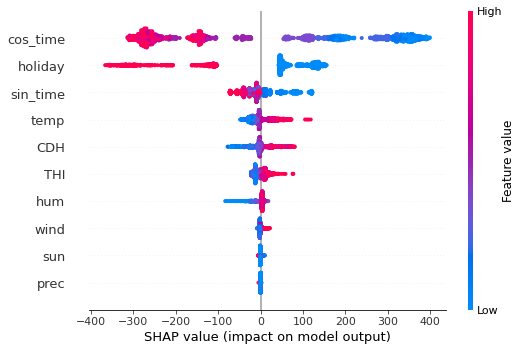

In [186]:
shap.summary_plot(shap_values, x_train_sets[1])